In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons

from scipy.optimize import minimize, Bounds
from scipy.interpolate import griddata, interp1d

from ipywidgets import *

In [20]:
# Constants
MU_B = 9.27400968e-24
HBAR = 1.054571726e-34
M = 2.838464e-25
E = 1.60217657e-19
EPS0 = 8.85418782e-12
C = 3e8
KHZ = 2*np.pi*1e3
MHZ = 2*np.pi*1e6

### 1. Defining all the errors

#### 1.1 Heating errors

The infidelity due to heating is well know and is analytically derived in the original MS paper [1]:

\begin{equation}
\epsilon_H = 1 - \frac{1}{8} (3 + 4 e^{-\frac{\dot{n}\pi}{2\sqrt{q}\eta\Omega}} + e^{-\frac{2\dot{n}\pi}{\sqrt{q}\eta\Omega}})
\end{equation}

Here the parameters are the usual, $\dot{n}$ is the heating rate in quanta/s, $\eta$ is the Lamb-Dicke parameter and $\Omega$ is the power of the sideband fields.

We define the heating error function :

In [3]:
def err_heating(ndot, eta, Om, fact) :
    return 1 - 1/8 *(3 + 4*np.exp(- ndot*np.pi/(2*fact * eta * Om)) + np.exp(-2 * ndot *np.pi/(fact*eta*Om)))

Notice the additional parameter $fact$. This is to take into account various gate schemes which reduce errors due to heating, such as Multi-Tone gates and Phase Modulated gates. For a 2-Tone gate (and the corresponding phase sequence), fact = 1/3 [2]. 

The heating rate is a function of the secular frequency, and also depends on which vibrational mode is used: center of mass (COM) or stretch (STR). The heating rate primarily depends on the electric field noise density $S_E$. We can make a fair assumption that the electric field PSD scales as 1/f, and can then talk about a scaled E-field spectral density, $\nu S_E(\nu)$. This is equivalent to quoting the value of the noise at 1 Hz. 

The heating rate functions for the COM and STR modes are [3]:

\begin{equation}
\dot{n}_{COM}(\nu_C) = \frac{e^2}{4 m \hbar \nu^2} \nu S_E(\nu)
\end{equation}

\begin{equation}
\dot{n}_{STR}(\nu_S) = \frac{e^2}{4 m }
\end{equation}

In [4]:
def ndot_COM(nu, nuSE) :
    # nu : COM mode frequency
    # nuSE : scaled E-field noise density
    return E**2/(4*M * HBAR * nu**2) * nuSE

def ndot_STR(nu, d, nuSE) :
    # nu : STR mode frequency
    # d : ion-electrode distance
    # nuSE : scaled E-field noise density
    return E**2/(4 * M * HBAR * nu**(10/3)) * nuSE/d**2 *(3* E **2/(2*np.pi*EPS0 * M))** (2/3) * 80

We now have all the functions necessary to compute errors due to heating in terms of the secular frequency $\nu$ and the scaled noise density $\nu S_E(\nu)$.

#### 1.2 Decoherence errors

We now define errors due to decoherence, ie. dephasing and depolarisation. Depolarisation errors can safely be neglected since the lifetime of our qubit is on the order of hours. Errors due to dephasing are simply approximated with an exponential decay :

In [5]:
def err_decoherence(t, T2) :
    # t : gate time
    # T2 : decoherence time (= dephasing time)
    return 1 - np.exp(-t/T2)

In order to assess the decoherence time T2, one must first determine the gate scheme, ie. what kind of Dynamical Decoupling (DD) is happening. In order to create a generalized error model, we can assume that whatever DD scheme is used leads to a filter function which samples magnetic field noise at a higher frequency with a small bandwidth. We can now choose a magnetic field noise value which represents the smallest possible magnetic field obtainable in a frequency range attainable by DD fields. To put this more simply: what's your smallest magnetic field noise between 10-50 kHz. From this value, we can calculate the decoherence time T2 :

In [6]:
def compute_T2(SB) :
    # SB : PSD of magnetic field Noise
    Gamma = 2*np.pi * MU_B**2 / HBAR**2  * SB
    return 1/Gamma

In general, the total magnetic field PSD is dominated by ambient noise in the lab. In a macroscopic experiment, this is usually quite low as the trap blades offer some sort of shielding, and decoherence times as high as 2.6 seconds were measured (without a gradient) [4]. On chips however, there is no intrinsic shielding and a coherence time of 0.6 seconds was measured [5].

Another contribution to the magnetic field PSD is voltage noise on the electrode. This displaces ions in a gradient and transforms into magnetic field noise. The higher the gradient and the closer the ions to the electrodes, the higher the noise. The transfer function from voltage noise to B field noise is :

In [7]:
def dBdV(nu, dzB, g) :
    # nu : secular frequency of COM mode
    # g : in units of m^-1, describes the electrode geometry
    return E * g * dzB /M/nu**2

Here the factor g is a reflection of the electrode geometry and the distance of the ion to the chip. Note that if the noise is perfectly correlated, the electrodes should in principle be symmetric about the ion and g = 0 (ie. voltage noise has no effect).

#### 1.3 Kerr coupling errors

The STR mode of our ion string is coupled to the radial modes. Fluctuations in the temperature of the radial mode will therefore lead to fluctuations of the axial STR mode frequency. The resulting errors are derived in [3], and here summarized to be :

\begin{equation}
\epsilon_k = K^2 \bar{n}_r (2 \bar{n}_r + 1)\frac{\pi^2}{\eta_s^2\Omega^2}\frac{1 + 2q(1 + 2\bar{n}_s)}{16q}
\end{equation}

Here, $\bar{n}_r$ is the radial mode's temperature, $\eta_s$ is the Lamb-Dicke parameter of the STR mode, q are the number of loops performed in phase space and $\bar{n}_s$ is the temperature of the STR mode. The radial modes are only Doppler cooled, so $\bar{n}_r$ is quite high, however the STR mode is typically sideband cooled so $\bar{n}_s < 1$ quanta. The Kerr error function is defined below :

In [8]:
def err_kerr(nu_s, eta_s, Om, nu_XY, nbar_r, nbar_s, K) :
    # nu_s : STR mode frequency
    # eta_s : STR mode Lamb-Dicke parameter
    # Om : MS sideband field power
    # nu_XY : Radial mode frequency
    # nbar_r : Radial mode temperature
    # nbar_s : STR mode temperature
    # K : Kerr coupling coefficient
    return K**2 * nbar_r * (2*nbar_r + 1) * (np.pi/eta_s/Om)**2 * (1 + 2*(1 + 2*nbar_s)/16)

In the previous equation, $K$ is the coupling coefficient of the STR and radial modes and is defined as :

\begin{equation}
K =  -\nu_s (\frac{1}{2} + \frac{\nu_s^2/2}{4\nu^2_r - \nu^2_s})(\frac{\nu_c}{\nu_r})(\frac{2\hbar\nu_c}{\alpha^2mc^2})^{1/3}
\end{equation}

It therefore becomes obvious that Kerr coupling errors quickly grow as the gap between STR mode and radial mode frequencies diminishes. $\nu_c$ and $\nu_s$ are the COM and STR mode frequencies, $\nu_r$ is the rocking mode frequency $\alpha$ is the fine structure constant and $c$ the speed of light. We define the Kerr coupling coefficient below :

In [9]:
ALPHA = 1/(4*np.pi*EPS0) * E**2/(HBAR * C)

def coefficientKerr(nu_s, nu_XY) :
    # nu_s : STR mode frequency
    # nu_XY : Radial mode frequency
    
    nu_c = nu_s/np.sqrt(3)
    nu_r = np.sqrt(nu_XY**2 - nu_c**2)
    
    return - nu_s * (0.5 + nu_s**2/2/(4*nu_r**2 - nu_s**2)) * (nu_c/nu_r) * (2*HBAR*nu_c/(ALPHA**2*M * C**2))**(1/3)

Finally, we can calculate the temperature from the Doppler cooling limit. Given the Linewidth of the cooling transition $\Gamma$,

\begin{equation}
\bar{n}_{min} = \frac{\Gamma}{2\nu}
\end{equation}

In [10]:
S_TO_P_LINEWIDTH = 19.6*MHZ

def compute_nbar_r(nu_XY) :
    # nu_XY : Radial mode frequency
    return S_TO_P_LINEWIDTH/2/nu_XY

#### 1.4 Off-resonant coupling errors

Off-resonant coupling errors arise from the coupling of the MS sideband fields to the carrier transitions. These errors are well characerized [8], and an analytical error term exists : 

\begin{equation}
\epsilon_{o} = N \frac{\Omega^2}{\delta^2}
\end{equation}

Here $\Omega$ is the MS sideband field power and $\delta$ corresponds to their detuning the carrier transition. When performing the gate on the STR mode, we set $\delta = \nu_{STR}$. Finally, we set the number of ions N = 2. 

In [11]:
def error_offres(Om, nu) :
    # Om : MS sideband power
    # delta : Detuning of field to carrier
    return (Om/nu)**2

For higher powers, off-resonant coupling errors quickly get out of control. To combat this, we can implement amplitude pulse shaping where the amplitudes of the SB fields are ramped up and down at the start and end of the gate. This will greatly reduce off-resonant coupling. In order to determine the increase of fidelity, a standard MS gate was numerically simulated for various gradients, powers and secular frequencies. With this library of results, we can extrapolate the fidelity for any set of parameters.

The simulation results are :

In [12]:
# Data obtained with simulations
data_off_res = [{'om': 20.0,  'dzB': 25.0,  'nu_data': [0.9995023759504151,   0.9997326153221033,   0.9997330048086357,   0.9997330094443002,   0.9997307480573094,   0.9997313267107552,   0.999722098727874,   0.9996885870276202,   0.9996461973412933,   0.9996498777349978]}, {'om': 20.0,  'dzB': 44.44444444444444,  'nu_data': [0.9997247930940907,   0.9997227138610177,   0.9997325068592796,   0.9997333593792734,   0.9997331052129423,   0.9997328399882849,   0.9997309217831488,   0.9997234662117647,   0.9997124175773312,   0.9997123506487582]}, {'om': 20.0,  'dzB': 63.888888888888886,  'nu_data': [0.996023614164799,   0.9997329754499904,   0.9997329460360342,   0.9997332126702682,   0.9997333428209593,   0.9997331654226109,   0.9997324290803858,   0.9997291042889296,   0.9997255904812159,   0.9997252764825849]}, {'om': 20.0,  'dzB': 83.33333333333333,  'nu_data': [0.9991911571927663,   0.9986385275201066,   0.9997240658286884,   0.9997308614755177,   0.9997320981956804,   0.9997331202885671,   0.9997329825851234,   0.9997313248315028,   0.9997297811282941,   0.9997293879256836]}, {'om': 20.0,  'dzB': 102.77777777777777,  'nu_data': [0.999720192808651,   0.9997331939660478,   0.9997330842138019,   0.999732586712194,   0.9997333115261335,   0.9997331310484476,   0.9997332416836608,   0.9997321172807764,   0.9997312182392956,   0.9997310191293242]}, {'om': 20.0,  'dzB': 122.22222222222221,  'nu_data': [0.9995643119640374,   0.9988956095493388,   0.9997139074508034,   0.9997311727079627,   0.9997313299373618,   0.9997333248129656,   0.9997333258256937,   0.9997326422136571,   0.999732244616968,   0.9997321618746684]}, {'om': 20.0,  'dzB': 141.66666666666666,  'nu_data': [0.9310971374918088,   0.9737004252584897,   0.9987353729370623,   0.9997323227576835,   0.9997332705945661,   0.9997333435532768,   0.99973312525966,   0.9997330203025003,   0.9997326078936767,   0.9997325279148881]}, {'om': 20.0,  'dzB': 161.1111111111111,  'nu_data': [0.9504038086322864,   0.9746034131213503,   0.9986233456198755,   0.9997331916725036,   0.9997322667532255,   0.9997333355822895,   0.9997332619525681,   0.999733245404086,   0.9997329521528967,   0.9997329019670574]}, {'om': 20.0,  'dzB': 180.55555555555554,  'nu_data': [0.9901742946941415,   0.963803096174081,   0.9952403587937743,   0.9996692249555773,   0.9997086311447684,   0.999727762879175,   0.999733318165438,   0.9997332827673432,   0.9997330969750532,   0.999733074274419]}, {'om': 20.0,  'dzB': 200.0,  'nu_data': [0.9630982893389409,   0.9996890255447639,   0.9943377105888545,   0.9995931007977112,   0.9996805428511747,   0.9997332459982895,   0.9997326693032972,   0.999733359786007,   0.9997332503234893,   0.9997331395839442]}, {'om': 28.88888888888889,  'dzB': 25.0,  'nu_data': [0.9986691952051522,   0.9997284320839839,   0.9997288942311955,   0.9997329223938821,   0.999733250526366,   0.9997328665454498,   0.9997270087631244,   0.9997206309513482,   0.9997219284070433,   0.9997224096438266]}, {'om': 28.88888888888889,  'dzB': 44.44444444444444,  'nu_data': [0.9868226819208067,   0.9997322221160863,   0.9997139955198636,   0.9997261811385216,   0.9997331235866943,   0.999733245710979,   0.9997326434767874,   0.9997305680059183,   0.9997306923408735,   0.9997287301565457]}, {'om': 28.88888888888889,  'dzB': 63.888888888888886,  'nu_data': [0.8992605380361943,   0.9987206812525229,   0.9997232476421644,   0.9997328907846469,   0.9997324870653961,   0.9997329629030481,   0.999733131789265,   0.9997329698618381,   0.9997324208968743,   0.9997319163225314]}, {'om': 28.88888888888889,  'dzB': 83.33333333333333,  'nu_data': [0.9697712037037636,   0.9868112547137995,   0.998961209619577,   0.9997155002766448,   0.9997272948980831,   0.9997329564288187,   0.9997333626032925,   0.9997332380830636,   0.9997330027583073,   0.9997326309468982]}, {'om': 28.88888888888889,  'dzB': 102.77777777777777,  'nu_data': [0.930330835016879,   0.9648008136010844,   0.9993040900862141,   0.9996540620584634,   0.9997237466525505,   0.9997319214449001,   0.9997333380871762,   0.9997333472276554,   0.9997332551858692,   0.9997330532793353]}, {'om': 28.88888888888889,  'dzB': 122.22222222222221,  'nu_data': [0.8666673215846872,   0.9996745903824406,   0.999497185429793,   0.9995555368167304,   0.9996912959337355,   0.9997330913577925,   0.9997303243487634,   0.9997333701341158,   0.9997330900495949,   0.9997331848190998]}, {'om': 28.88888888888889,  'dzB': 141.66666666666666,  'nu_data': [0.9919751242937427,   0.9715483513741353,   0.9992484648475538,   0.9996286444961381,   0.9997330196737815,   0.9997316682884685,   0.9997281022357982,   0.9997325462408846,   0.9997332877672671,   0.9997332142739132]}, {'om': 28.88888888888889,  'dzB': 161.1111111111111,  'nu_data': [0.9001172567058299,   0.972738451531572,   0.9971413871709209,   0.9996452503284659,   0.9997324852016939,   0.9997305081133484,   0.999733091425779,   0.9997333043420604,   0.9997333750426901,   0.9997333120651869]}, {'om': 28.88888888888889,  'dzB': 180.55555555555554,  'nu_data': [0.9933359533263749,   0.9841060463779896,   0.99427158565774,   0.9989707593884911,   0.9995731071557307,   0.9996738927390869,   0.9997331791775299,   0.9997328657897548,   0.9997333192139878,   0.9997331608849851]}, {'om': 28.88888888888889,  'dzB': 200.0,  'nu_data': [0.9903450764097343,   0.9951424167846531,   0.9544725247565388,   0.9993216970946301,   0.9992843907542903,   0.9996540925283376,   0.9997189166703321,   0.9997295692012544,   0.9997330825158645,   0.9997333738543878]}, {'om': 37.77777777777778,  'dzB': 25.0,  'nu_data': [0.9971791830902733,   0.9991954216526884,   0.9997320383218472,   0.9997287292417728,   0.9997324028071479,   0.9997331546544443,   0.9997333464888303,   0.9997325143032846,   0.9997279447831681,   0.9997176057103718]}, {'om': 37.77777777777778,  'dzB': 44.44444444444444,  'nu_data': [0.8178490123976291,   0.994478432137283,   0.9997229421866118,   0.9997318792998109,   0.9997319115221405,   0.9997323356802881,   0.9997331091713628,   0.9997333448495931,   0.9997323349899596,   0.9997297494049124]}, {'om': 37.77777777777778,  'dzB': 63.888888888888886,  'nu_data': [0.8335355047927917,   0.9991055252893429,   0.9997008138227158,   0.9996919055549334,   0.9997230164954901,   0.9997327794032319,   0.9997330745332231,   0.9997332277870891,   0.9997332109130697,   0.9997321634663681]}, {'om': 37.77777777777778,  'dzB': 83.33333333333333,  'nu_data': [0.7770952723538364,   0.9980668174749423,   0.9959266568296928,   0.9997326576864359,   0.999732178602167,   0.99972092022038,   0.9997329745727842,   0.9997332574473666,   0.9997332661536735,   0.9997331127721979]}, {'om': 37.77777777777778,  'dzB': 102.77777777777777,  'nu_data': [0.7900688145547895,   0.9949900966987588,   0.9747883465109548,   0.9989348707673992,   0.9997316647177364,   0.9997310501795471,   0.9997327202044842,   0.9997331133303576,   0.9997330626531338,   0.9997332843130793]}, {'om': 37.77777777777778,  'dzB': 122.22222222222221,  'nu_data': [0.9889957500495632,   0.9967305171187778,   0.9508684919641671,   0.9992950251605731,   0.9997214196391225,   0.9996680700896357,   0.9997297623336003,   0.9997330790999203,   0.9997332977774043,   0.9997333246430681]}, {'om': 37.77777777777778,  'dzB': 141.66666666666666,  'nu_data': [0.9040644568783693,   0.9997279488054704,   0.9922316228751102,   0.9983795535700397,   0.99972603539577,   0.9997144363101912,   0.9997329430409678,   0.9997286230728872,   0.9997329908030351,   0.9997330407140965]}, {'om': 37.77777777777778,  'dzB': 161.1111111111111,  'nu_data': [0.9779650830023245,   0.9635932518354666,   0.9961227979414669,   0.9996039966425356,   0.9997298257722254,   0.9997187693225008,   0.9997294082448444,   0.9997312967195923,   0.9997332352968715,   0.9997333131216226]}, {'om': 37.77777777777778,  'dzB': 180.55555555555554,  'nu_data': [0.9524920302196992,   0.8709770763734677,   0.9117351490612441,   0.9779584916438637,   0.9995472594861073,   0.999732986432422,   0.9996877941901157,   0.9997324219963075,   0.9997263893878645,   0.999731931409509]}, {'om': 37.77777777777778,  'dzB': 200.0,  'nu_data': [0.9658059880897373,   0.9993393739989235,   0.9267731276036085,   0.9863496476263953,   0.9980741872059672,   0.9997326496413025,   0.9996967493953337,   0.9997330271443444,   0.9997245895942318,   0.9997331419802011]}, {'om': 46.66666666666667,  'dzB': 25.0,  'nu_data': [0.9944151229737942,   0.9997324356360492,   0.9997326357960697,   0.9997323310592428,   0.9997317825060346,   0.9997321045566971,   0.9997326707575871,   0.9997332122347858,   0.9997333786525607,   0.9997323706720611]}, {'om': 46.66666666666667,  'dzB': 44.44444444444444,  'nu_data': [0.6611946835013071,   0.9993488725540131,   0.9997327478023006,   0.9997320238510495,   0.9997310511243239,   0.9997323063627447,   0.9997323519415974,   0.9997330700811612,   0.9997332455784309,   0.9997333318746016]}, {'om': 46.66666666666667,  'dzB': 63.888888888888886,  'nu_data': [0.6659525163462175,   0.9167471048108049,   0.9995324700075737,   0.9995416721999799,   0.999731651976391,   0.9997236047594844,   0.9997326542992985,   0.9997323260648678,   0.9997331612196113,   0.9997333134532902]}, {'om': 46.66666666666667,  'dzB': 83.33333333333333,  'nu_data': [0.6989757357314762,   0.953716948761475,   0.981713896232517,   0.9983281957539824,   0.9994811076936957,   0.9997325988365606,   0.9997309332102874,   0.9997328036287966,   0.9997327464469936,   0.9997331895223954]}, {'om': 46.66666666666667,  'dzB': 102.77777777777777,  'nu_data': [0.9994342190139975,   0.9680591008573033,   0.9958001504545163,   0.9963667660649608,   0.9997281615875887,   0.9996464404860743,   0.9997109640042369,   0.9997328366796394,   0.9997330401876374,   0.9997327829041014]}, {'om': 46.66666666666667,  'dzB': 122.22222222222221,  'nu_data': [0.9593345260796646,   0.8731758454491857,   0.9000422531075608,   0.9880217991403817,   0.9995914748982144,   0.999524421666959,   0.9997110393384109,   0.9997296405991751,   0.9997325440749582,   0.9997331592756685]}, {'om': 46.66666666666667,  'dzB': 141.66666666666666,  'nu_data': [0.9882895310553114,   0.8704722589101637,   0.8771339464918753,   0.9772735657473244,   0.9983731721081949,   0.9997327384645662,   0.9997295338405989,   0.9997254613084746,   0.9997301520878352,   0.9997331246316051]}, {'om': 46.66666666666667,  'dzB': 161.1111111111111,  'nu_data': [0.9806809486376914,   0.9255267335726962,   0.9976078361712694,   0.9789439105501259,   0.9958550164820429,   0.999638304927693,   0.9997321459376413,   0.9997048153244454,   0.9997186761046621,   0.9997329898683961]}, {'om': 46.66666666666667,  'dzB': 180.55555555555554,  'nu_data': [0.784635792690618,   0.9956633393404206,   0.9997100063344067,   0.9550593700445211,   0.999733089314959,   0.9981281571399739,   0.9997327555310399,   0.9996983651233691,   0.9997330337350959,   0.9997327081755184]}, {'om': 46.66666666666667,  'dzB': 200.0,  'nu_data': [0.9787689331295537,   0.99924589691283,   0.9955184266927202,   0.9898924387433555,   0.9950273429379264,   0.9988250515023347,   0.9997067283600911,   0.9996037606082244,   0.9997170710059682,   0.9997288011177562]}, {'om': 55.55555555555556,  'dzB': 25.0,  'nu_data': [0.9995475847917447,   0.9996919170490403,   0.9997292425362997,   0.9997328280195019,   0.9997305337251605,   0.9997312775669888,   0.9997319793748879,   0.9997321708003069,   0.9997328595110141,   0.9997333723584423]}, {'om': 55.55555555555556,  'dzB': 44.44444444444444,  'nu_data': [0.5678558493939546,   0.9971632169119744,   0.99972614038472,   0.9995691642313577,   0.9997221111479766,   0.9997304683252564,   0.9997318982335974,   0.9997321651450669,   0.9997325406460406,   0.9997332407857467]}, {'om': 55.55555555555556,  'dzB': 63.888888888888886,  'nu_data': [0.8051193062168032,   0.7825282177546196,   0.9690622244390464,   0.9989319324971738,   0.9995919884699302,   0.9997317818733816,   0.9997322265267793,   0.9997311615833184,   0.9997324591534928,   0.9997329992513342]}, {'om': 55.55555555555556,  'dzB': 83.33333333333333,  'nu_data': [0.892587496738084,   0.999271723584657,   0.9658353958034912,   0.9940735519344238,   0.9997321016895832,   0.9996580565166243,   0.9997276404152471,   0.999729489824873,   0.9997299594073027,   0.9997329155298662]}, {'om': 55.55555555555556,  'dzB': 102.77777777777777,  'nu_data': [0.9422376127254942,   0.8785914021770245,   0.9043153208997453,   0.9966790563657834,   0.9980302052992264,   0.9996015229013546,   0.9997146357841755,   0.9997267790677316,   0.9997280281255947,   0.9997305078533593]}, {'om': 55.55555555555556,  'dzB': 122.22222222222221,  'nu_data': [0.9875570967197514,   0.8868549081467915,   0.9734795708238062,   0.9991353759052602,   0.9995414667550486,   0.9997324762410349,   0.9996317735891198,   0.9997327727222745,   0.9997194464588002,   0.9997296963238185]}, {'om': 55.55555555555556,  'dzB': 141.66666666666666,  'nu_data': [0.722736516982223,   0.997290287223429,   0.8336121170986022,   0.9938382577700724,   0.9984583063692344,   0.999606084007813,   0.9997237695120194,   0.9996880072883803,   0.9997323653392474,   0.9997328994813686]}, {'om': 55.55555555555556,  'dzB': 161.1111111111111,  'nu_data': [0.8730502657184744,   0.9581549945861548,   0.9995455077782707,   0.9855825613082055,   0.999729386823385,   0.9997310784319299,   0.9997297529581602,   0.9997323712756617,   0.999732661204694,   0.9997206259612421]}, {'om': 55.55555555555556,  'dzB': 180.55555555555554,  'nu_data': [0.9669841950227863,   0.8183697909185985,   0.9992846380267276,   0.9994608577090467,   0.9612027059354782,   0.9964179925048605,   0.9997273547010823,   0.9997289004700247,   0.9996779770943073,   0.9997134324957095]}, {'om': 55.55555555555556,  'dzB': 200.0,  'nu_data': [0.9767724995294323,   0.9884713255823028,   0.9975775191388083,   0.8880301431146121,   0.9838790045294047,   0.9906914910286315,   0.9983948609891067,   0.9997233419681988,   0.9996768920456947,   0.9997316061131174]}, {'om': 64.44444444444444,  'dzB': 25.0,  'nu_data': [0.508849211258495,   0.9832317192260399,   0.9988806529987087,   0.9996842645731119,   0.9997305439984171,   0.9997329616885312,   0.9997325455825288,   0.999732286753605,   0.9997318517115562,   0.9997322374791261]}, {'om': 64.44444444444444,  'dzB': 44.44444444444444,  'nu_data': [0.9997149671945565,   0.7829548657521349,   0.9954174945057919,   0.9990878386019953,   0.9997314735557574,   0.9997325598142184,   0.9997317682570523,   0.9997315122293928,   0.9997320126754676,   0.9997325113031172]}, {'om': 64.44444444444444,  'dzB': 63.888888888888886,  'nu_data': [0.9924906058932609,   0.7251977379895121,   0.9195142600583354,   0.9992468576210844,   0.9995528803864198,   0.9997248318362664,   0.9997320729225219,   0.9997317314569774,   0.9997322567875074,   0.9997324267939337]}, {'om': 64.44444444444444,  'dzB': 83.33333333333333,  'nu_data': [0.903894517128759,   0.999404756219695,   0.9994527290339574,   0.9782642284034032,   0.9994941251418998,   0.9997325611114032,   0.9997320349969255,   0.999732097097639,   0.9997323661193162,   0.9997317960349154]}, {'om': 64.44444444444444,  'dzB': 102.77777777777777,  'nu_data': [0.997777076246495,   0.6850589001881888,   0.8663609636017257,   0.9310184263051635,   0.9965129184538071,   0.9997326326309968,   0.9997308782007029,   0.999728344135166,   0.9997212265967137,   0.9997324884501976]}, {'om': 64.44444444444444,  'dzB': 122.22222222222221,  'nu_data': [0.657889685206435,   0.9993139748995061,   0.8160794481826696,   0.9741689411372497,   0.9996766437472647,   0.9986129282244688,   0.9997298491845146,   0.9996257546117717,   0.9996962700918953,   0.9997328235242053]}, {'om': 64.44444444444444,  'dzB': 141.66666666666666,  'nu_data': [0.6972564535219525,   0.9416819225374424,   0.9934783403571201,   0.8940276144813998,   0.998129448930013,   0.9994304915756633,   0.9996994918412587,   0.9996895964492606,   0.9997250872993027,   0.9997270996185895]}, {'om': 64.44444444444444,  'dzB': 161.1111111111111,  'nu_data': [0.9378326043864738,   0.7725124913913547,   0.8692948325757542,   0.939001458160748,   0.965431046198719,   0.9957988894256168,   0.9995980542171753,   0.9997325517122114,   0.9996865256698394,   0.9997328336260196]}, {'om': 64.44444444444444,  'dzB': 180.55555555555554,  'nu_data': [0.8939741310514866,   0.9950010395110722,   0.8347346188940867,   0.9996779775191895,   0.9404822674701032,   0.9985792047097288,   0.9995078948715521,   0.9997320232298177,   0.9996908444950462,   0.9997101434434502]}, {'om': 64.44444444444444,  'dzB': 200.0,  'nu_data': [0.9545976786476967,   0.9971707241672837,   0.9974530349558409,   0.8208723042849158,   0.9413090110073398,   0.9996613515008846,   0.9975570033950321,   0.9997136652695469,   0.9997326175786313,   0.9997126298234533]}, {'om': 73.33333333333334,  'dzB': 25.0,  'nu_data': [0.8827166723073834,   0.996067987661408,   0.9991492526810412,   0.999677834980196,   0.9997035474784324,   0.9997323588733649,   0.9997330554485799,   0.9997325937949559,   0.9997326319530961,   0.9997323214513604]}, {'om': 73.33333333333334,  'dzB': 44.44444444444444,  'nu_data': [0.9244497662926344,   0.634639368681512,   0.9905545672462018,   0.9997320186518369,   0.9995847988522674,   0.9997066385929523,   0.9997199535475075,   0.9997301807107851,   0.9997318399003139,   0.9997320640085734]}, {'om': 73.33333333333334,  'dzB': 63.888888888888886,  'nu_data': [0.48844283350959616,   0.6293865069788037,   0.9745263614732804,   0.9993247473487907,   0.9997261683005634,   0.9997286674227825,   0.9997104944026038,   0.999727107647685,   0.9997319027620573,   0.9997312378141645]}, {'om': 73.33333333333334,  'dzB': 83.33333333333333,  'nu_data': [0.7290175362416235,   0.6034495078001588,   0.7467323183329376,   0.9881045676988456,   0.9942518641281434,   0.9997293070710839,   0.9995544543352733,   0.9996847255022037,   0.9997321180635738,   0.9997321910576238]}, {'om': 73.33333333333334,  'dzB': 102.77777777777777,  'nu_data': [0.9112306822192309,   0.9479539946140237,   0.908829605287128,   0.8637054701801583,   0.9982045645651565,   0.9990004493030512,   0.9995757067149076,   0.9997300195905288,   0.9996973523457654,   0.9997323060925867]}, {'om': 73.33333333333334,  'dzB': 122.22222222222221,  'nu_data': [0.743384304196702,   0.9704001935292935,   0.9982163722617016,   0.9141265312256291,   0.9969592290511834,   0.9983711855314836,   0.9997305504441943,   0.999713290400887,   0.9997310947308921,   0.9997247301701245]}, {'om': 73.33333333333334,  'dzB': 141.66666666666666,  'nu_data': [0.9290707287729798,   0.6962276247386793,   0.8026761165007515,   0.8903325375738016,   0.9743918086292966,   0.9953180480931121,   0.998964528723868,   0.9997321945689677,   0.9997301362485363,   0.9997289759320733]}, {'om': 73.33333333333334,  'dzB': 161.1111111111111,  'nu_data': [0.5838042367723992,   0.999373639489931,   0.993412036189056,   0.9989259210509221,   0.9987803513690067,   0.9862626044219054,   0.9993957949808406,   0.9997210414182005,   0.999711892309336,   0.9997277399487388]}, {'om': 73.33333333333334,  'dzB': 180.55555555555554,  'nu_data': [0.589405378919938,   0.8549719737035733,   0.9905986032496421,   0.996258214801182,   0.9112616110525819,   0.9997154513354503,   0.9988150563783001,   0.9992113536525805,   0.9997318408420899,   0.999694196747639]}, {'om': 73.33333333333334,  'dzB': 200.0,  'nu_data': [0.7617222980010734,   0.9457553089548869,   0.9819018304943702,   0.8768030758219236,   0.9373518680752054,   0.9825636683430207,   0.9910471484886464,   0.9996787313312263,   0.9997326224744459,   0.9995414989225453]}, {'om': 82.22222222222223,  'dzB': 25.0,  'nu_data': [0.9995106579711736,   0.9997324398865551,   0.9997323543518424,   0.9997231160430561,   0.9997325997161832,   0.9997286495534298,   0.9997331049630068,   0.9997331652773216,   0.9997327316663197,   0.9997327667322935]}, {'om': 82.22222222222223,  'dzB': 44.44444444444444,  'nu_data': [0.42955891427701504,   0.705733127152204,   0.9997156157906645,   0.9996245034412758,   0.9996602394817364,   0.9997313618482635,   0.999728601405212,   0.9997283691062495,   0.9997307047669162,   0.9997324064503794]}, {'om': 82.22222222222223,  'dzB': 63.888888888888886,  'nu_data': [0.9074488186229763,   0.9997333211995899,   0.8171075358822046,   0.9997167454830779,   0.999468324089776,   0.9996939097587065,   0.999731765811302,   0.9997105987797493,   0.999731944788152,   0.9997305525920431]}, {'om': 82.22222222222223,  'dzB': 83.33333333333333,  'nu_data': [0.5640449860767771,   0.6172169341294086,   0.9067958438236944,   0.9951062367892037,   0.9908881521326666,   0.9997293473594235,   0.9997302157836977,   0.9997326056961229,   0.9996986132645433,   0.9997264805311612]}, {'om': 82.22222222222223,  'dzB': 102.77777777777777,  'nu_data': [0.5045283286741558,   0.994919427203938,   0.9531903309005346,   0.99617681467075,   0.9583120594579185,   0.9994030558981103,   0.9996087356360924,   0.9997299274108067,   0.999731671990211,   0.9997318460232486]}, {'om': 82.22222222222223,  'dzB': 122.22222222222221,  'nu_data': [0.9674767906139142,   0.7193901277731473,   0.995208885299013,   0.9718581758315635,   0.9234609179145727,   0.9985484461277834,   0.9984502823888153,   0.9993305431830026,   0.9997324286834769,   0.9997286077553583]}, {'om': 82.22222222222223,  'dzB': 141.66666666666666,  'nu_data': [0.8027045314543739,   0.9811617675081141,   0.8011999356955545,   0.995416332343873,   0.9541915440928717,   0.9957065179576531,   0.9992222761944936,   0.9997275141485298,   0.9996589382979927,   0.9997172231627283]}, {'om': 82.22222222222223,  'dzB': 161.1111111111111,  'nu_data': [0.512670750616402,   0.8037827434440381,   0.9860020810123666,   0.9983477037863323,   0.9133442288093978,   0.9989567408321783,   0.9997002757924763,   0.999482467111529,   0.9997296967299945,   0.9996695782359247]}, {'om': 82.22222222222223,  'dzB': 180.55555555555554,  'nu_data': [0.5328212113322205,   0.9453310300304038,   0.8350949970421391,   0.9673633263078938,   0.8051083201781496,   0.9970713800041143,   0.9979892336606875,   0.9997159813588204,   0.9997276961028364,   0.9995244248783404]}, {'om': 82.22222222222223,  'dzB': 200.0,  'nu_data': [0.9996169005546801,   0.9968510359470238,   0.974615530088218,   0.7284728245660185,   0.9727980426892666,   0.9204862021049236,   0.9878441809516013,   0.9993811924707446,   0.999673714299907,   0.999724504914142]}, {'om': 91.11111111111111,  'dzB': 25.0,  'nu_data': [0.161248696527612,   0.9961773329775365,   0.9992005726503104,   0.999729190753134,   0.9997246997072043,   0.9997328014717252,   0.9997322715115352,   0.9997329656206733,   0.9997331172255307,   0.9997327289167806]}, {'om': 91.11111111111111,  'dzB': 44.44444444444444,  'nu_data': [0.6652510865469825,   0.5886935307304307,   0.9992440263138422,   0.9969742583946029,   0.9989371526568722,   0.9997291394283636,   0.9997304370352829,   0.9997313735835337,   0.9997329649147721,   0.9997325463824154]}, {'om': 91.11111111111111,  'dzB': 63.888888888888886,  'nu_data': [0.42041860407857284,   0.3957243072470775,   0.9995760845598324,   0.9946804651720265,   0.9950876303471791,   0.9997011091911112,   0.9996822910470822,   0.999687007919366,   0.9997150788586223,   0.9997319874503372]}, {'om': 91.11111111111111,  'dzB': 83.33333333333333,  'nu_data': [0.798081353870809,   0.9681357593994581,   0.7158807489348527,   0.9955773321784701,   0.9898436629790792,   0.9997099838929436,   0.9990651062688224,   0.9995828172336431,   0.9997026317303581,   0.9997290462709679]}, {'om': 91.11111111111111,  'dzB': 102.77777777777777,  'nu_data': [0.8446203515172962,   0.9739439875956248,   0.9964695734902658,   0.7360694047034111,   0.9308607535264926,   0.9927684943478466,   0.9995545270154034,   0.9994290550441949,   0.999660775235048,   0.9997263099691301]}, {'om': 91.11111111111111,  'dzB': 122.22222222222221,  'nu_data': [0.8939606682154776,   0.9375041756989722,   0.991143670133472,   0.6840562863515635,   0.9997333274179591,   0.9959410853746311,   0.9994507207866172,   0.9997243994985332,   0.999522840324814,   0.9997320962169429]}, {'om': 91.11111111111111,  'dzB': 141.66666666666666,  'nu_data': [0.8761767391576669,   0.9792483431463784,   0.9995655478170802,   0.7165029267586817,   0.9636165722711467,   0.9859885920259436,   0.9986606248920047,   0.9997318919425355,   0.9996815772693075,   0.9996893724399893]}, {'om': 91.11111111111111,  'dzB': 161.1111111111111,  'nu_data': [0.6335867987615766,   0.9292464028484536,   0.9724848814374581,   0.8676990046569717,   0.949268645863386,   0.9933430994676278,   0.981901820804547,   0.9993710751228563,   0.9997326367464896,   0.9997260517075965]}, {'om': 91.11111111111111,  'dzB': 180.55555555555554,  'nu_data': [0.9997333538336595,   0.9939215865685376,   0.9715952649309689,   0.6757751836321723,   0.9778751396458363,   0.9198989598990229,   0.9916786268031438,   0.999732681855437,   0.9997257232150639,   0.9997324591065646]}, {'om': 91.11111111111111,  'dzB': 200.0,  'nu_data': [0.765682091824406,   0.9910898528210822,   0.6421771563413883,   0.778571949942933,   0.7454359102218189,   0.8633175390355757,   0.9558446842398169,   0.9920918699305747,   0.9969404674121695,   0.9997324993954156]}, {'om': 100.0,  'dzB': 25.0,  'nu_data': [0.9926194423796645,   0.7642182977573988,   0.9991501309054208,   0.9997315122185368,   0.9997151705185381,   0.9997237543895544,   0.9997328430338008,   0.9997313964503943,   0.9997332672426774,   0.9997333215502987]}, {'om': 100.0,  'dzB': 44.44444444444444,  'nu_data': [0.8361885699925804,   0.9780525064122615,   0.9970843652203893,   0.9906430613313669,   0.9992504863220097,   0.9996512484504548,   0.9997087166850162,   0.9997327103719972,   0.9997329263473071,   0.9997326123896105]}, {'om': 100.0,  'dzB': 63.888888888888886,  'nu_data': [0.9883954127024501,   0.9997332621786588,   0.6280941095407698,   0.9984203029483105,   0.996949481811596,   0.9996657202226148,   0.9997222189441276,   0.9997128853146952,   0.9997327968443307,   0.9997269609359095]}, {'om': 100.0,  'dzB': 83.33333333333333,  'nu_data': [0.4661923430750093,   0.9360244123252104,   0.4865855515706489,   0.9567924809831394,   0.9960555038499612,   0.9971872626195009,   0.9994501755225138,   0.9996715019113965,   0.999729492227374,   0.9997325575410806]}, {'om': 100.0,  'dzB': 102.77777777777777,  'nu_data': [0.6881923500366086,   0.9997332920147314,   0.9985043819132682,   0.7355354473931388,   0.9550598403840413,   0.9945390069249128,   0.9972141142087371,   0.9993254941964731,   0.9997012578637264,   0.9996989883790321]}, {'om': 100.0,  'dzB': 122.22222222222221,  'nu_data': [0.9979541966377177,   0.9969617760632333,   0.7168816431360195,   0.9013952886520975,   0.8186821151702198,   0.9476204175073242,   0.9966678333802073,   0.9997318676281284,   0.9995523504252477,   0.9996221573399894]}, {'om': 100.0,  'dzB': 141.66666666666666,  'nu_data': [0.749718599560772,   0.4788457110913097,   0.9697952466023434,   0.9992457628487107,   0.7781953689001097,   0.8898960402615969,   0.9940350437722475,   0.9992124955253835,   0.9997083814670731,   0.9996358034084063]}, {'om': 100.0,  'dzB': 161.1111111111111,  'nu_data': [0.7000319528084061,   0.506280197917114,   0.5681258052311825,   0.7842955609277636,   0.7473482077888959,   0.9997332360579254,   0.9649802822412971,   0.9997270108912726,   0.9997327537551309,   0.9997118539751817]}, {'om': 100.0,  'dzB': 180.55555555555554,  'nu_data': [0.8816999515485533,   0.9199599465410963,   0.8689874074138594,   0.9922652691475027,   0.9994772794419297,   0.9988729299150426,   0.9295206321429236,   0.9929633692129778,   0.9995997053766498,   0.9997326397656826]}, {'om': 100.0,  'dzB': 200.0,  'nu_data': [0.40933045283630504,   0.6669185237727643,   0.6047694598439249,   0.666800079895941,   0.9738196391576008,   0.9917298606392636,   0.9958676321116724,   0.9954703012972337,   0.9982933063715242,   0.9996940174248986]}]

The off-resonant coupling errors with pulse shaping obtained with the function below.  

In [13]:
# Reformat data
x_list = []
y_list = []

nu_list = np.linspace(100, 400, 10)

for data in data_off_res :
    for i in range(len(nu_list)) :
        x_list += [[data['om'], data['dzB'], nu_list[i]]]
        y_list += [data['nu_data'][i]]
        
# Off-resonant errors with pulse shaping
def err_offres_ps(Om, dzB, nu_c_list) :
    
    # Build interpolation function
    nu_c_list_interp = np.linspace(100, 400, 10)*KHZ
    fids_offres = [1 - griddata(x_list, y_list, [Om/KHZ, dzB, nu_c/KHZ], method='linear')[0] for nu_c in nu_c_list_interp]
    interp_func = interp1d(nu_c_list_interp/KHZ, np.log10(fids_offres), kind='linear')
    
    errors_out = []
    # The simulations only provide data for 100 > nu_c > 400. If nu is found
    # outside of this range, simply clip the result.
    for nu_c in nu_c_list/KHZ :
        if nu_c < 100 :
            errors_out += [10**interp_func(100)]
        elif nu_c > 400 :
            errors_out += [10**interp_func(400)]
        else :
            errors_out += [10**interp_func(nu_c)]

    return errors_out

#### 1.5 Total errors

We can now compute the total error budget for a set of parameters. We'll calculate the infidelities for a range of secular frequencies. Note that we define the list of secular frequencies in terms of the COM mode, but we assume that the gate is performed on the STR mode. 

In [14]:
DIST_ELECTRODE = 150e-6 # Assume typical distance to electrode for chips
HEATING_FACTOR = 1/3 # 1/3 is typical for schemes such as the 2T MS gate or
                     # Phase modulated gates.
GATE_TIME_COST = 1.25 # Increased gate time when using heating robust gates
G_FACTOR_CHIP = 50.10 # Geometric factor for voltage noise found by numerically 
               # simulating chip geometries.
    
STR_TEMP = 0.2 # Temperature of STR mode, assuming sideband cooling
    
def compute_eta(nu, dzB) :
    # Calculate the LB parameter
    # nu : vibrational frequency 
    # dzB : gradient
    return 1/np.sqrt(2) * MU_B * dzB/ (HBAR * nu) * np.sqrt(HBAR/(2*M * nu))

    
def compute_total_errors(nu_c_list, Om, dzB, nuSE, SBa, SV, nu_XY, pulse_shaping = False) :
    # nu_c : list of COM frequencies
    
    errors_h = [] # Heating errors
    errors_d = [] # Decoherence errors
    errors_k = [] # Kerr coupling errors
    errors_o = [] # Off-res coupling errors
    
    # Loop over ever COM frequency :
    for nu_c in nu_c_list :

        nu_s = np.sqrt(3) * nu_c
        eta_s = compute_eta(nu_s, dzB)

        #------------------------------
        # Compute errors due to heating
        #------------------------------

        # Compute STR mode heating rate
        ndot_s = ndot_STR(nu_s, DIST_ELECTRODE, nuSE) 

        errors_h += [err_heating(ndot_s, eta_s, Om, HEATING_FACTOR)]

        #------------------------------
        # Compute errors due to decoherence
        #------------------------------
        # Calculate gate time. Note that the 1.25 factor is the tradeoff for using
        # MTMS or PM gates. A HEATING_FACTOR > 1 means a smaller gate time. 
        tgate = np.pi/(eta_s * Om) * GATE_TIME_COST

        # Calculate B-field PSD due to Voltage noise
        SBv = dBdV(nu_c, dzB, G_FACTOR_CHIP)**2 * SV
        SBtot = SBa + SBv # Total B field noise = Voltage noise + Ambient noise
        # Compute decoherence time
        T2 = compute_T2(SBtot)

        errors_d += [err_decoherence(tgate, T2)]
    
        #------------------------------
        # Compute errors due to Kerr coupling
        #------------------------------
        
        # Calculate Kerr coefficient
        Kcoeff = coefficientKerr(nu_s, nu_XY)
        
        # Calculate radial mode temperature 
        nbar_r = compute_nbar_r(nu_XY)
        
        errors_k += [err_kerr(nu_s, eta_s, Om, nu_XY, nbar_r, STR_TEMP, Kcoeff)]
        
    #------------------------------
    # Compute errors due to off-resonant coupling
    #------------------------------

    # Using pulse shaping or not?
    if pulse_shaping :
        errors_o = err_offres_ps(Om, dzB, nu_c_list)
    else :    
        errors_o = error_offres(Om, nu_c_list)
        
    return np.array(errors_h), np.array(errors_d), np.array(errors_k), np.array(errors_o)

### 2. Interactive plotting

Let us first define the default errors. We choose parameters which are easily attainable on chips. 

$\nu S_E(\nu)$ : Given that we've measured a scaled electric field noise of $10^{-7}$ at 10 K [6], we can expect **$\nu S_E(\nu) = 10^{-6}$** at 70 K. 

$\nu_{XY}$ : Typical radial mode frequencies are around 1.5 MHz

$S_{B, ambient}$ : For the macroscopic trap, we estimate the ambient B-field to be at most $1\times 10^{-23} \ T^2/Hz$. For chips, this becomes $1 \times 10^{-22} \ T^2/HZ$. 

$S_V$ : The Stahl voltage source is characterized to have noise around $100 \times 10^{-18} \ V^2/Hz$. Using DACs however, we'd like more speed which costs us more noise, and the voltage noise is estimated to be $10^{-16} - 10^{-14} \ V^2/Hz$.

$\partial_zB$ : The gradient achieved with permanent magnets is 25 T/m on the macro and 100 T/m on the high-fid experiment. With CCWs, this could go as high up as 200 T/m. 

$\Omega$ : The MS sideband powers depend on the microwave power available. On the macro, powers of 40 kHz can be achieved. With in vacuum delivery, this could potentially pass 100 kHz. 

We therefore choose the default values to be :

In [15]:
nuSE_0, nu_XY_0, SBa_0, Om_0, dzB_0, SV_0 = 1e-6, 1.5*MHZ, 1e-22, 70*KHZ, 100, 1e-15

Let us now calculate the corresponding errors : 

In [16]:
nu_c_list = np.linspace(100, 500, 50)*KHZ

err_h_0, err_d_0, err_k_0, err_o_0 = compute_total_errors(nu_c_list, Om_0, dzB_0, nuSE_0, SBa_0, SV_0, nu_XY_0, True)
err_tot_0 = err_h_0 + err_d_0 + err_k_0 + err_o_0

We'd also like to define a function which optimizes the secular frequency and finds the highest fidelity. While we're at it, let's also find the corresponding gate time. 

In [21]:
def optimizeFidelity(nu_c_list, err_list) :
    # Input : List of COM sec freqs and errors
    # Output : Minimum achievable fidelity and corresponding optimal secular freq
    
    def opt_func(nu_c) :
        interp_func = interp1d(nu_c_list, err_list, kind='linear')
        if nu_c >= 500*KHZ :
            return 1
        if nu_c <= 100*KHZ :
            return 1
        else :
            return interp_func(nu_c)
    
    # Minimize errors
    bnds = [100*KHZ, 500*KHZ]
    res = minimize(opt_func, (300*KHZ), method='Nelder-Mead')#, bounds=bnds)
    
    err_min = res.fun
    nu_opt = res.x
    
    return err_min, nu_opt[0]

def compute_tgate(nu, dzB, Om) :
    eta = compute_eta(nu, dzB)
    tgate = 2*np.pi/eta/Om
    return tgate * GATE_TIME_COST

Let's now find our optimized fidelity for the previous parameters :

In [22]:
err_min_0, nu_opt_0 = optimizeFidelity(nu_c_list, err_tot_0)
tgate_0 = compute_tgate(nu_opt_0*np.sqrt(3), dzB_0, Om_0)

print('Minimal error : ' + str(err_min_0))
print('Optimal secular frequency : ' + str(nu_opt_0/KHZ))
print('Gate Time : ' + str(tgate_0))

Minimal error : 0.01718381193397309
Optimal secular frequency : 418.3673469442876
Gate Time : 0.002046923423708276


And now for the actual plotting : 

<IPython.core.display.Javascript object>


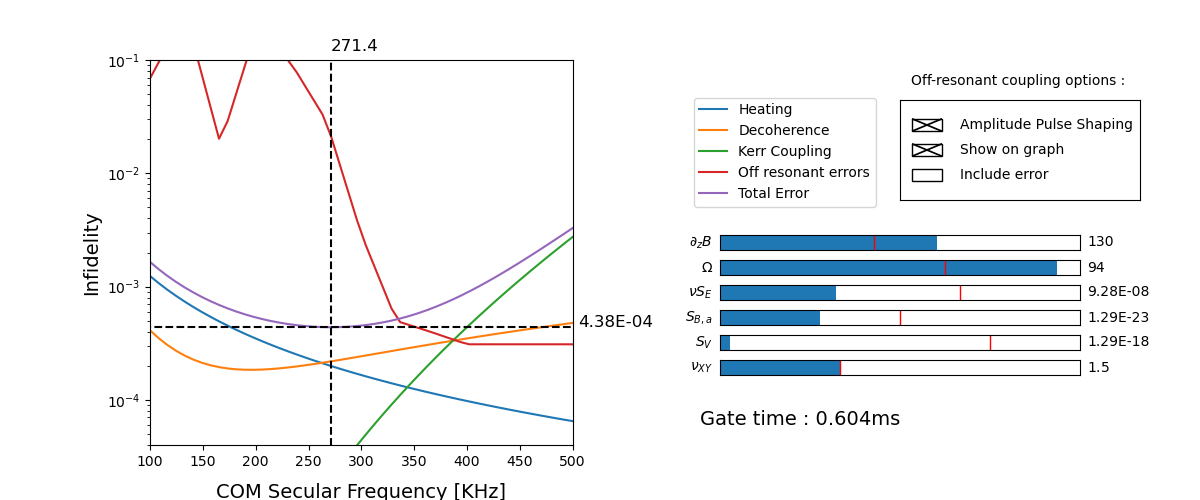

In [19]:
# Off-res option buttons
CB_AMP_PS = 0
CB_SHOW_GRAPH = 1
CB_INC_ERR = 2

def compute_tgate(nu, dzB, Om) :
    eta = compute_eta(nu, dzB)
    tgate = np.pi/eta/Om
    return tgate

class Sliderlog(Slider):
    # Custom class for a Slider widget with logarithmic display
    def set_val(self, val):

        xy = self.poly.xy
        if self.orientation == 'vertical':
            xy[1] = 0, val
            xy[2] = 1, val
        else:
            xy[2] = val, 1
            xy[3] = val, 0
        self.poly.xy = xy
        self.valtext.set_text(self.valfmt % 10**val)   # Modified to display 10**val instead of val
        if self.drawon:
            self.ax.figure.canvas.draw_idle()
        self.val = val
        if not self.eventson:
            return
        for cid, func in self.observers.items():
            func(10**val)

# Initialize an interactive notebook
%matplotlib notebook

fig = plt.figure(figsize = (12, 5), dpi = 80)
ax = fig.add_subplot(1, 2, 1)

ax.set_yscale('log')
ax.set_ylim(4e-5, 1e-1)
ax.set_xlim(100, 500)

ax.set_xlabel('COM Secular Frequency [KHz]', fontsize = 14, labelpad = 10)
ax.set_ylabel('Infidelity', fontsize = 14)

# Plot each error and assign a handle to it
heating_plot, = ax.plot(nu_c_list/KHZ, err_h_0, label = 'Heating')
decoherence_plot, = ax.plot(nu_c_list/KHZ, err_d_0, label = 'Decoherence')
kerr_plot, = ax.plot(nu_c_list/KHZ, err_k_0, label = 'Kerr Coupling')
offres_plot, = ax.plot(nu_c_list/KHZ, err_o_0, label = 'Off resonant errors')
tot_plot, = ax.plot(nu_c_list/KHZ, err_tot_0, label = 'Total Error')

# Plot optimal fidelity and secular frequency
errmin_plot, = ax.plot([0, 1e3], [err_min_0, err_min_0], 'k--')
nuopt_plot, = ax.plot([nu_opt_0/KHZ, nu_opt_0/KHZ], [0, 1], 'k--')
#Plot text for optimal fidelity
errmin_txt = ax.text(505, err_min_0, '%.2E'%err_min_0, fontsize = 12)
nuopt_txt = ax.text(nu_opt_0/KHZ, 1.2e-1, '%.1f'%(nu_opt_0/KHZ), fontsize = 12)

# Show gate time text 
tgate_txt = ax.text(620, 6e-5, 'Gate time : %.3f'%(tgate_0*1e3) + 'ms', fontsize = 14)

# Define the position for each slider
SLDR_X0, SLDR_W, SLDR_H  = 0.6, 0.3, 0.03
dzB_slider_ax = plt.axes([SLDR_X0, 0.5, SLDR_W, SLDR_H])
Om_slider_ax = plt.axes([SLDR_X0, 0.45, SLDR_W, SLDR_H])
nuSE_slider_ax = plt.axes([SLDR_X0, 0.4, SLDR_W, SLDR_H])
SBa_slider_ax = plt.axes([SLDR_X0, 0.35, SLDR_W, SLDR_H])
SV_slider_ax = plt.axes([SLDR_X0, 0.3, SLDR_W, SLDR_H])
nuXY_slider_ax = plt.axes([SLDR_X0, 0.25, SLDR_W, SLDR_H])

# Create each slider
dzB_slider = Slider(dzB_slider_ax, r'$\partial_zB$', 25, 200, valinit=dzB_0, valfmt="%i")
Om_slider = Slider(Om_slider_ax, r'$\Omega$', 20, 100, valinit=Om_0/KHZ, valfmt="%i")
nuSE_slider = Sliderlog(nuSE_slider_ax, r'$\nu S_E$', -8, -5, valinit= np.log10(nuSE_0), valfmt='%.2E')
SBa_slider = Sliderlog(SBa_slider_ax, r'$S_{B, a}$', -24, -20, valinit=np.log10(SBa_0), valfmt="%.2E")
SV_slider = Sliderlog(SV_slider_ax, r'$S_{V}$', -18, -14, valinit=np.log10(SV_0), valfmt="%.2E")
nuXY_slider = Slider(nuXY_slider_ax, r'$\nu_{XY}$', 1, 2.5, valinit= nu_XY_0/MHZ)

# Create check buttons for off-res errors options
cb_ax = plt.axes([.75, 0.6, 0.2, 0.2])
cb_labels = ['Amplitude Pulse Shaping', 'Show on graph', 'Include error']
cb_visibility = [True, True, True]
check_button = CheckButtons(cb_ax, cb_labels, cb_visibility)

# Global update function
def update(dzB):
    
    # Update each parameter
    dzB = dzB_slider.val
    Om = Om_slider.val * KHZ
    nuSE = 10**nuSE_slider.val
    SBa = 10**SBa_slider.val
    SV = 10**SV_slider.val
    nu_XY = nuXY_slider.val * MHZ
    
    # Get off-res options status
    cb_status = check_button.get_status()
    
    PULSE_SHAPING = cb_status[CB_AMP_PS] and cb_status[CB_SHOW_GRAPH]
    
    # Recompute all errors
    err_h, err_d, err_k, err_o = compute_total_errors(nu_c_list, Om, dzB, nuSE, SBa, SV, nu_XY, PULSE_SHAPING)
    err_tot = err_h + err_d + err_k
    
    if cb_status[CB_INC_ERR] and cb_status[CB_SHOW_GRAPH]:
        err_tot += err_o
    
    # Update plots for each error
    heating_plot.set_ydata(err_h)
    decoherence_plot.set_ydata(err_d)
    kerr_plot.set_ydata(err_k)
    tot_plot.set_ydata(err_tot)
    
    if cb_status[CB_SHOW_GRAPH] : offres_plot.set_ydata(err_o)
    else : offres_plot.set_ydata([10]*len(err_o))

    # Recompute optimal fidelity/sec freq
    err_min, nu_opt = optimizeFidelity(nu_c_list, err_tot)
    
    # Update optimal fid plots
    errmin_plot.set_ydata([err_min, err_min])
    nuopt_plot.set_xdata([nu_opt/KHZ, nu_opt/KHZ])
    
    errmin_txt.set_text('%.2E'%err_min)
    nuopt_txt.set_text('%.1f'%(nu_opt/KHZ))
    errmin_txt.set_position([505, err_min])
    nuopt_txt.set_position([nu_opt/KHZ, 1.2e-1])
    
    # Update gate time
    tgate = compute_tgate(nu_opt*np.sqrt(3), dzB, Om)
    tgate_txt.set_text('Gate time : %.3f'%(tgate*1e3) + 'ms')
    
    fig.canvas.draw_idle()     
    plt.draw()
        
# Detect widget interactions
dzB_slider.on_changed(update)
Om_slider.on_changed(update)
nuSE_slider.on_changed(update)
SBa_slider.on_changed(update)
SV_slider.on_changed(update)
nuXY_slider.on_changed(update)
check_button.on_clicked(update)

ax.legend(loc = 'upper left', bbox_to_anchor=(1.27, 0.92))
ax.text(820, 6e-2, 'Off-resonant coupling options :')
plt.show()

### 3. Sources

[1] A. Sorensen and K. Molmer, Phys. Rev. A 62, 022311, 2000

[2] A. Webb, PhD Thesis, University of Sussex, 2018

[3] J. Randall, PhD Thesis, University of Sussex, 2016

[4] Macroscopic experiment journal entries

[5] E. Potter, PhD Thesis, University of Sussex, 2018

[6] Z. Romaszko et al, Nature Review Physics 2, 285-299, 2020